# Simple FEM for a simple shear problem

## Create rectangular mesh

<skfem MeshQuad1 object>
  Number of elements: 1024
  Number of vertices: 1089
  Number of nodes: 1089
  Named boundaries [# facets]: left [32], bottom [32], right [32], top [32]


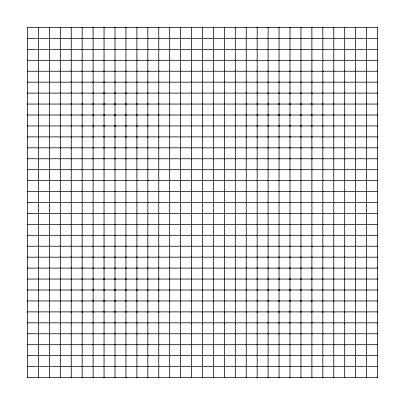

In [42]:

import numpy as np
import skfem as fem
from skfem.helpers import ddot, dot, eye, sym_grad, trace
from skfem.visuals.matplotlib import draw, plot

DELTA = 0.1
MU = 1.0
LBD = 2.0

mesh = fem.MeshQuad().refined(5)

# Visualize the mesh
draw(mesh, figsize=(5, 5))
print(mesh)

## Create the FEM function space

In [43]:
# Define second order quads and define a 2d variable on it (u1 and u2)
element = fem.ElementVector(fem.ElementQuad2(), 2)
# Function space
basis = fem.Basis(mesh, element)

## Material model

A single 2D ply stiffness tensor is given as 

$$
\sigma = 2\mu \nabla^s u + \lambda^* \textrm{tr}(\nabla^s u)I
$$

with 

$$
\lambda^* = \lambda  
$$

for plane strain or 

$$
\lambda^* = \frac{2\lambda\mu}{\lambda+2\mu}
$$

for plane stress.

In [44]:
def sigma(eps):
    return  2.0 * MU * eps + LBD * eye(trace(eps), 2)

## Bilinear form of the weak form

$$ \int_\Omega \sigma \left (\nabla^s u \right) : \nabla^s v dV = \int_\Omega f \cdot v dV $$

In [45]:
@fem.BilinearForm
def k(u, v, w):
    return ddot(sigma(sym_grad(u)), sym_grad(v))

@fem.LinearForm
def b(v, w):
    f = np.zeros(v.shape)
    return dot(f, v)

## Boundary conditions

Left: 

$$ u_1 = 0$$

Bottom: 

$$ u_2 = 0$$

Right: 

$$ u_1 = \varepsilon_0 L\\  
   u_2 =0
$$

In [46]:
# Get all degrees of freedom and set appropiate entry to prescribed BCs.
u = basis.zeros()
u[basis.get_dofs({"top"}).nodal['u^1']] = DELTA
u[basis.get_dofs({"top"}).facet['u^1']] = DELTA


cons = np.concatenate([
    basis.get_dofs({"bottom"}).nodal['u^1'], 
    basis.get_dofs({"bottom"}).facet['u^1'], 
    basis.get_dofs({"bottom"}).nodal['u^2'],
    basis.get_dofs({"bottom"}).facet['u^2'],
    basis.get_dofs({"top"}).nodal['u^1'],
    basis.get_dofs({"top"}).facet['u^1'],
    basis.get_dofs({"top"}).nodal['u^2'],
    basis.get_dofs({"top"}).facet['u^2']
    ]
)

# Get remaining degrees of freedom
I = basis.complement_dofs(cons)

## Assemble and solve

In [47]:
# Assemble matrices
K = fem.asm(k, basis)
B = fem.asm(b, basis)

# Solve the problem 
u = fem.solve(*fem.condense(K, B, x=u, I=I))

## Postprocessing

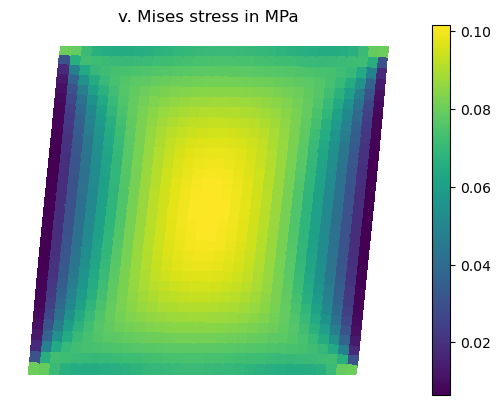

In [51]:
# Get nodal positions 
x = np.zeros_like(u)
dofs0 = list(basis.nodal_dofs[0]) 
dofs1 = list(basis.nodal_dofs[1]) 
x[dofs0] = mesh.doflocs[0]
x[dofs1] = mesh.doflocs[1]

# Compute stress on quadrature points
ui = basis.interpolate(u)
xi = basis.interpolate(x)
E = sym_grad(ui)
S = sigma(E)

# Compute deformed mesh
mesh.doflocs[0] += u[dofs0]
mesh.doflocs[1] += u[dofs1]

# Plot results
p = plot(mesh, np.mean(S[0,1], axis=-1), colorbar=True, cmap="viridis")
p.set_title("v. Mises stress in MPa")
p.show()